<div id="1" style="background-color: #1a1a1a; padding: 10px; border-radius: 10px; border: 2px solid black;">
    <h1 style="font-family:  'Garamond', 'Lucida Sans', sans-serif; text-align: center; color: #fff; font-weight: bold; font-size: 42px;">
    Imports & Dataset Overview
    </h1>
    <a class="anchor"  id="chapter1"></a>
</div>

In [1]:
# %load_ext cudf.pandas

In [2]:
import numpy as np 
import pandas as pd 
import warnings
warnings.filterwarnings("ignore")
import os
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score, StratifiedKFold,GridSearchCV
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

In [3]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/playground-series-s4e7/sample_submission.csv
/kaggle/input/playground-series-s4e7/train.csv
/kaggle/input/playground-series-s4e7/test.csv


In [4]:
sample_submission=pd.read_csv("/kaggle/input/playground-series-s4e7/sample_submission.csv")
train_data=pd.read_csv("/kaggle/input/playground-series-s4e7/train.csv",index_col="id")
test_data=pd.read_csv("/kaggle/input/playground-series-s4e7/test.csv",index_col="id")

In [5]:
train_data.head()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
id,,,,,,,,,,,
0,Male,21,1,35.0,0,1-2 Year,Yes,65101.0,124.0,187,0
1,Male,43,1,28.0,0,> 2 Years,Yes,58911.0,26.0,288,1
2,Female,25,1,14.0,1,< 1 Year,No,38043.0,152.0,254,0
3,Female,35,1,1.0,0,1-2 Year,Yes,2630.0,156.0,76,0
4,Female,36,1,15.0,1,1-2 Year,No,31951.0,152.0,294,0


In [6]:
print("train shape: ", train_data.shape, "test shape: ", test_data.shape)

train shape:  (11504798, 11) test shape:  (7669866, 10)


In [7]:
train_data.Response.value_counts()

Response
0    10089739
1     1415059
Name: count, dtype: int64

<div id="2" style="background-color: #1a1a1a; padding: 10px; border-radius: 10px; border: 2px solid black;">
    <h1 style="font-family:  'Garamond', 'Lucida Sans', sans-serif; text-align: center; color: #fff; font-weight: bold; font-size: 42px;">
    Exploratory Data Analysis
    </h1>
    <a class="anchor"  id="chapter2"></a>
</div>

Text(0.5, 1.0, 'Previously Insured Distribution')

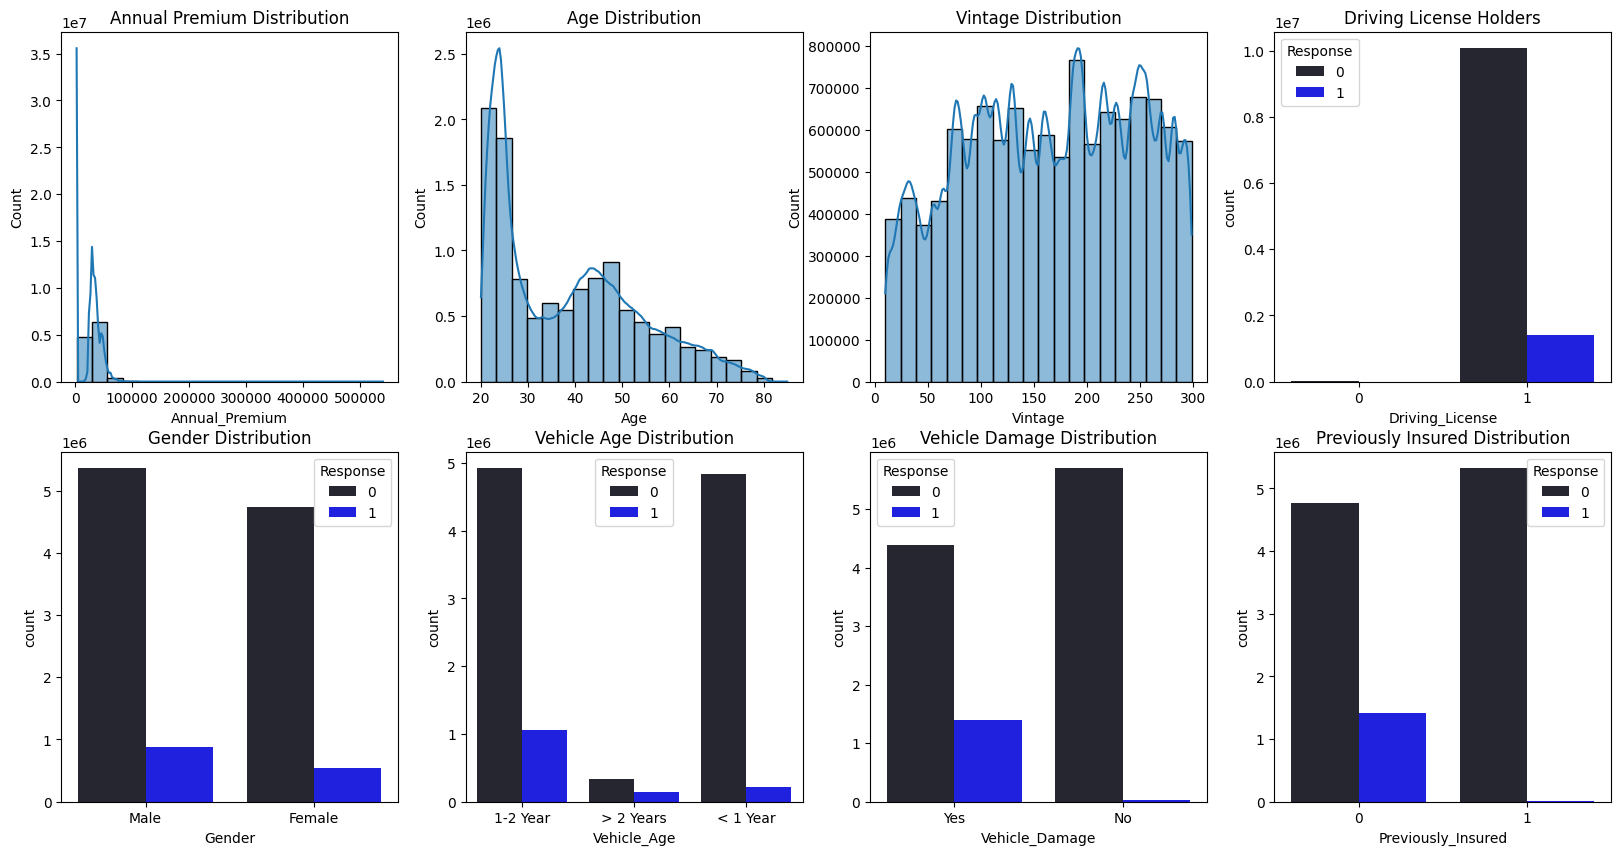

In [8]:
# Create the subplot for the remaining plots
fig, axes = plt.subplots(2, 4, figsize=(20, 10))

sns.histplot(ax=axes[0, 0], x='Annual_Premium',data=train_data, kde=True, bins=20, palette='dark:blue' )
axes[0, 0].set_title('Annual Premium Distribution')
sns.histplot(ax=axes[0, 1], x='Age',data=train_data, kde=True, bins=20, palette='dark:blue')
axes[0, 1].set_title('Age Distribution')
sns.histplot(ax=axes[0, 2], x='Vintage', kde=True, bins=20, data=train_data, palette='dark:blue')
axes[0, 2].set_title('Vintage Distribution')
sns.countplot(ax=axes[0, 3], x='Driving_License', data=train_data, hue='Response', palette='dark:blue')
axes[0, 3].set_title('Driving License Holders')
sns.countplot(ax=axes[1, 0], x='Gender', data=train_data, hue='Response', palette='dark:blue') 
axes[1, 0].set_title('Gender Distribution')
sns.countplot(ax=axes[1, 1], x='Vehicle_Age', data=train_data, hue='Response', palette='dark:blue') 
axes[1, 1].set_title('Vehicle Age Distribution')
sns.countplot(ax=axes[1, 2], x='Vehicle_Damage', data=train_data, hue='Response', palette='dark:blue') 
axes[1, 2].set_title('Vehicle Damage Distribution')
sns.countplot(ax=axes[1, 3], x='Previously_Insured', data=train_data, hue='Response', palette='dark:blue') 
axes[1, 3].set_title('Previously Insured Distribution')

<div id="2" style="background-color: #1a1a1a; padding: 10px; border-radius: 10px; border: 2px solid black;">
    <h1 style="font-family:  'Garamond', 'Lucida Sans', sans-serif; text-align: center; color: #fff; font-weight: bold; font-size: 42px;">
    Data Cleaning
    </h1>
    <a class="anchor"  id="chapter1"></a>
</div>

In [9]:
train_data['Vehicle_Age'] = train_data['Vehicle_Age'].replace({'< 1 Year': 1, '1-2 Year': 2, '> 2 Years': 3})
test_data['Vehicle_Age'] = test_data['Vehicle_Age'].replace({'< 1 Year': 1, '1-2 Year': 2, '> 2 Years': 3})

label_encoder = LabelEncoder()
train_data['Gender'] = label_encoder.fit_transform(train_data['Gender'])
test_data['Gender'] = label_encoder.fit_transform(test_data['Gender'])
train_data['Vehicle_Damage'] = label_encoder.fit_transform(train_data['Vehicle_Damage'])
test_data['Vehicle_Damage'] = label_encoder.fit_transform(test_data['Vehicle_Damage'])


In [10]:
train_data = pd.get_dummies(train_data, columns=['Gender'], dtype=int)
test_data = pd.get_dummies(test_data, columns=['Gender'], dtype=int)

cols = list(train_data.columns)
cols.append(cols.pop(cols.index('Response')))
train_data = train_data[cols]
train_data.head()

,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Gender_0,Gender_1,Response
id,,,,,,,,,,,,
0,21,1,35.0,0,2,1,65101.0,124.0,187,0,1,0
1,43,1,28.0,0,3,1,58911.0,26.0,288,0,1,1
2,25,1,14.0,1,1,0,38043.0,152.0,254,1,0,0
3,35,1,1.0,0,2,1,2630.0,156.0,76,1,0,0
4,36,1,15.0,1,2,0,31951.0,152.0,294,1,0,0


<div id="3" style="background-color: #1a1a1a; padding: 10px; border-radius: 10px; border: 2px solid black;">
    <h1 style="font-family:  'Garamond', 'Lucida Sans', sans-serif; text-align: center; color: #fff; font-weight: bold; font-size: 42px;">
    Feature Engineering
    </h1>
    <a class="anchor"  id="chapter3"></a>
</div>

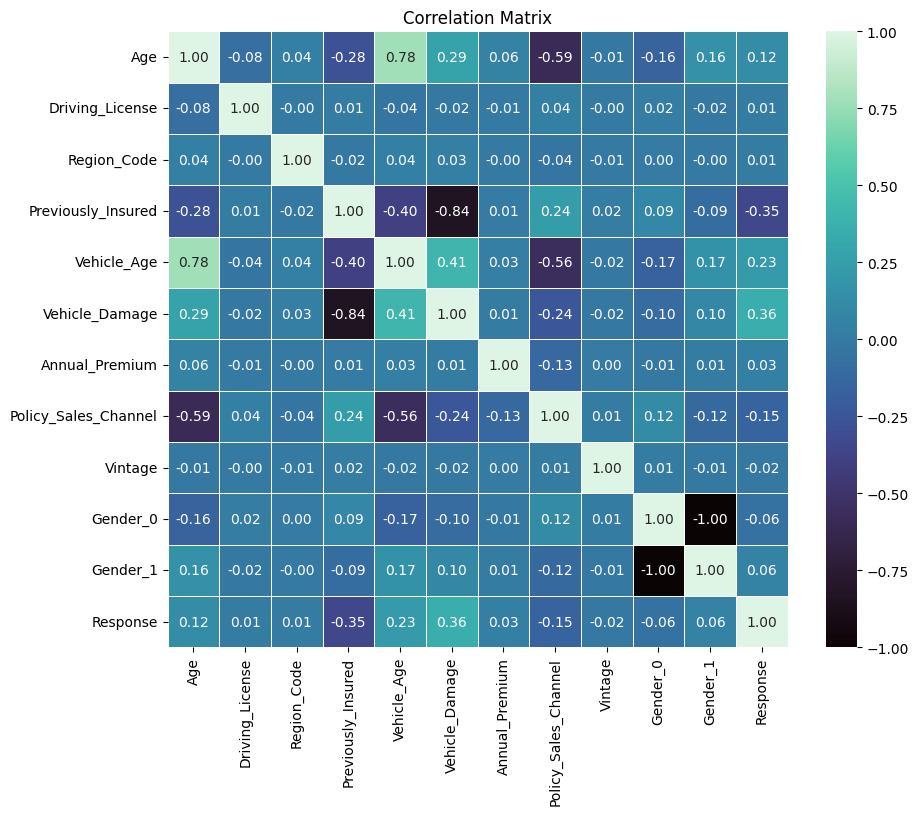

In [11]:
corr_matrix = train_data.corr(method='pearson')
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='mako', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

In [12]:
# Loop over bottom diagonal of correlation matrix
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        # Print variables with high correlation
        if 0.8 < abs(corr_matrix.iloc[i, j]) < 1 :
            print(corr_matrix.columns[i], corr_matrix.columns[j], corr_matrix.iloc[i, j])

Vehicle_Damage Previously_Insured -0.8362139380196396


Vehicle_Damage and Previously_Insured are correlated with each other, so they add the same information for the target value, but since Previously_Insured is a little bit less correlated with the targe variable Response we can remove it

In [13]:
# train_data = train_data.drop('Previously_Insured', axis=1)
# test_data = test_data.drop('Previously_Insured', axis=1)
# train_data.head()

In [14]:
X_train_data=train_data.drop('Response', axis=1)
y_train_data=train_data["Response"]

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X_train_data, y_train_data , random_state=1, test_size = .2)

<div id="4" style="background-color: #1a1a1a; padding: 10px; border-radius: 10px; border: 2px solid black;">
    <h1 style="font-family:  'Garamond', 'Lucida Sans', sans-serif; text-align: center; color: #fff; font-weight: bold; font-size: 42px;">
    Modeling
    </h1>
    <a class="anchor"  id="chapter4"></a>
</div>

In [16]:
# # Classifier dictionary
# classifiers = {
#     'pipeline_rf': RandomForestClassifier(random_state=42),
#     'pipeline_svc': SVC(probability=True, random_state=42),
#     'pipeline_knn': KNeighborsClassifier(),
#     'pipeline_xgb': XGBClassifier(random_state=42, device="cuda"),
#     'pipeline_lgb': LGBMClassifier(random_state=42, verbose=-1, device="cuda"),
#     'pipeline_cat': CatBoostClassifier(random_state=42, verbose=0, task_type='cuda'),    
# }

# # Create pipelines
# for key, classifier in classifiers.items():
#     globals()[key] = Pipeline([
#         ('scaler', StandardScaler()),
#         ('classifier', classifier)
#     ])


In [17]:
best_classifiers = {
    'pipeline_xgb': XGBClassifier(random_state=42, colsample_bytree=0.7, gamma=0.6, max_depth=4, n_estimators=130, subsample=1.0, device='cuda'),
    'pipeline_lgb': LGBMClassifier(random_state=42, verbose=-1,colsample_bytree=0.8, max_depth=4, min_child_samples=100, n_estimators=130,num_leaves=30, subsample=1.0,device='GPU'),
    'pipeline_catboost': CatBoostClassifier(random_state=42, verbose=0, depth=5, iterations = 300, l2_leaf_reg = 9, learning_rate=0.1, task_type='GPU'),    
}
# Create pipelines
for key, classifier in best_classifiers.items():
    globals()[key] = Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', classifier)
    ])

In [18]:
# # Random Forest pipeline
# pipeline_rf = Pipeline([
#     ('scaler', StandardScaler()),
#     ('classifier', RandomForestClassifier(random_state=42))
# ])

# # Support Vector Machine pipeline
# pipeline_svc = Pipeline([
#     ('scaler', StandardScaler()),
#     ('classifier', SVC(probability=True, random_state=42)) 
# ])

# # K-Nearest Neighbors pipeline
# pipeline_knn = Pipeline([
#     ('scaler', StandardScaler()),
#     ('classifier', KNeighborsClassifier())
# ])
# # XGboost pipeline
# pipeline_xgb = Pipeline([
#     ('scaler', StandardScaler()),
#     ('classifier', XGBClassifier(random_state=42))
# ])

# # LGBM pipeline
# pipeline_lgb = Pipeline([
#     ('scaler', StandardScaler()),
#     ('classifier', LGBMClassifier(random_state=42))
# ])

# # Catboost pipeline
# pipeline_cat = Pipeline([
#     ('scaler', StandardScaler()),
#     ('classifier', CatBoostClassifier(random_state=42))
# ])

In [19]:
# List of pipelines
pipelines = [pipeline_xgb, pipeline_lgb,pipeline_catboost]
pipeline_names = ['XGBoost', 'LightGBM', 'CatBoost']


In [20]:
# Cross-validation
for pipe, name in zip(pipelines, pipeline_names):
    cv = StratifiedKFold(n_splits=5)
    auc_scores = cross_val_score(pipe, X_train, y_train, cv=cv, scoring='roc_auc')
    print(f'{name} Cross-Validation AUC-ROC: {auc_scores.mean():.4f} ± {auc_scores.std():.3f}')

XGBoost Cross-Validation AUC-ROC: 0.8761 ± 0.000


1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.


LightGBM Cross-Validation AUC-ROC: 0.8699 ± 0.000
CatBoost Cross-Validation AUC-ROC: 0.8708 ± 0.000


In [21]:
# # Plot ROC curve
# plt.figure(figsize=(10, 8))

# for pipe, name in zip(pipelines, pipeline_names):
#     pipe.fit(X_train, y_train)
#     y_pred_proba = pipe.predict_proba(X_test[:1000])[:, 1]
#     fpr, tpr, _ = roc_curve(y_test[:1000], y_pred_proba)
#     plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc_score(y_test[:1000], y_pred_proba):.2f})')

# plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('ROC Curve')
# plt.legend(loc='lower right')
# plt.show()

In [22]:
# # GridSearch for XGboost
# param_grid_xgb = {
#     'classifier__n_estimators': [130, 150, 170],
#     'classifier__max_depth': [4, 5, 6],
#     'classifier__gamma': [0.4, 0.5, 0.6],
#     'classifier__subsample': [1.0, 1.3, 1.5],
#     'classifier__colsample_bytree': [0.6, 0.7, 0.8]
# }

# grid_search_xgb = GridSearchCV(pipeline_xgb, param_grid_xgb, cv=5, scoring='roc_auc', )
# grid_search_xgb.fit(X_train[:10000], y_train[:10000])
# print(f'Best Parameters for XGBoost: {grid_search_xgb.best_params_}')
# print(f'Best AUC-ROC for XGBoost: {grid_search_xgb.best_score_:.5f}')

In [23]:


# # GridSearch for CatBoost
# param_grid_cat = {
#     'classifier__iterations': [150, 200, 250,300],
#     'classifier__depth': [5, 10, 15],
#     'classifier__learning_rate': [0.01, 0.05,  0.1],
#     'classifier__l2_leaf_reg': [0, 1, 3, 5, 9]
# }

# grid_search_cat = GridSearchCV(pipeline_cat, param_grid_cat, cv=5, scoring='roc_auc')
# grid_search_cat.fit(X_train[:100000], y_train[:100000])

# print(f'Best Parameters for CatBoost: {grid_search_cat.best_params_}')

In [24]:
# # GridSearch for LightGBM
# param_grid_lgb = {
#     'classifier__n_estimators': [130, 150, 170],
#     'classifier__max_depth': [4, 5, 6],
#     'classifier__num_leaves': [30, 50, 100, 150],
#     'classifier__min_child_samples': [5, 20, 50, 100],
#     'classifier__subsample': [1.0, 1.3, 1.5],
#     'classifier__colsample_bytree': [0.6, 0.7, 0.8]
# }

# grid_search_lgb = GridSearchCV(pipeline_lgb, param_grid_lgb, cv=5, scoring='roc_auc')
# grid_search_lgb.fit(X_train[:10000], y_train[:10000])

# print(f'Best Parameters for LightGBM: {grid_search_lgb.best_params_}')
# print(f'Best AUC-ROC for LightGBM: {grid_search_lgb.best_score_:.5f}')

In [25]:
pipeline_xgb.fit(X_train, y_train)
predictions = pipeline_xgb.predict_proba(test_data)[:, 1]
sample_submission['Response'] = predictions
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head()

,id,Response
0,11504798,0.008162
1,11504799,0.407294
2,11504800,0.223999
3,11504801,0.000147
4,11504802,0.037569
